# Intel Image Classification 辨識

![alt text](https://storage.googleapis.com/kaggle-datasets-images/111880/269359/a16c143f44e79d17f54d5e670f16e03b/dataset-cover.jpg?t=2019-02-01-19-30-12)
[Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification?datasetId=111880&sortBy=voteCount)

* buildings -> 0
* forest -> 1
* glacier -> 2
* mountain -> 3
* sea -> 4
* street -> 5

## 步驟1：載入套件及影像資料

In [1]:
import numpy as np
import pandas as pd
import os, cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
from tqdm import tqdm
import tensorflow as tf
# Keras
# from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from IPython.display import SVG



In [2]:
class_names = ['buildings', 'forest', 'glacier','mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['./input/seg_train/seg_train', './input/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading ./input/seg_train/seg_train


100%|██████████| 2382/2382 [00:01<00:00, 1298.78it/s]


Loading ./input/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1335.18it/s]


### 存取np.array 上傳Colab 執行用

In [4]:
# np.savez('train.npz', Xarr=x_train, Yarr=y_train)
# np.savez('test.npz', Xarr=x_test, Yarr=y_test)

In [5]:
# loaded_data = np.load('train.npz')
# x_train = loaded_data['Xarr']
# y_train = loaded_data['Yarr']
# loaded_data = np.load('test.npz')
# x_test = loaded_data['Xarr']
# y_test = loaded_data['Yarr']

### 繼續執行程式

In [6]:
x_train, y_train = shuffle(x_train, y_train, random_state=25)

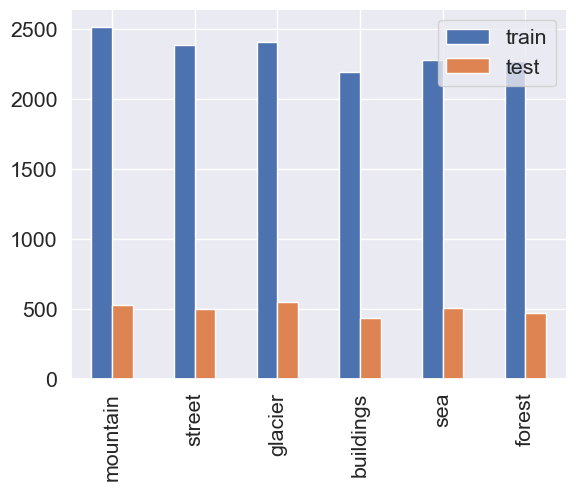

In [7]:
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

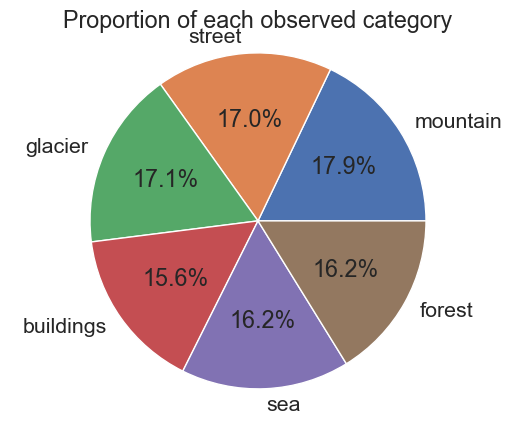

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
x_train = x_train / 255.0 
x_test = x_test / 255.0

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

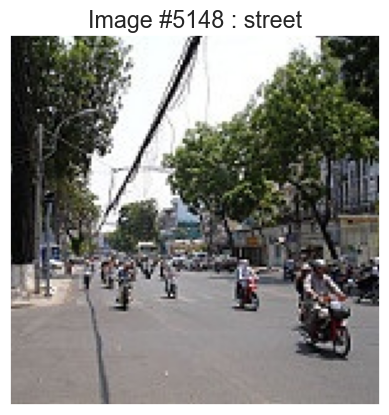

In [11]:
display_random_image(class_names, x_train, y_train)

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

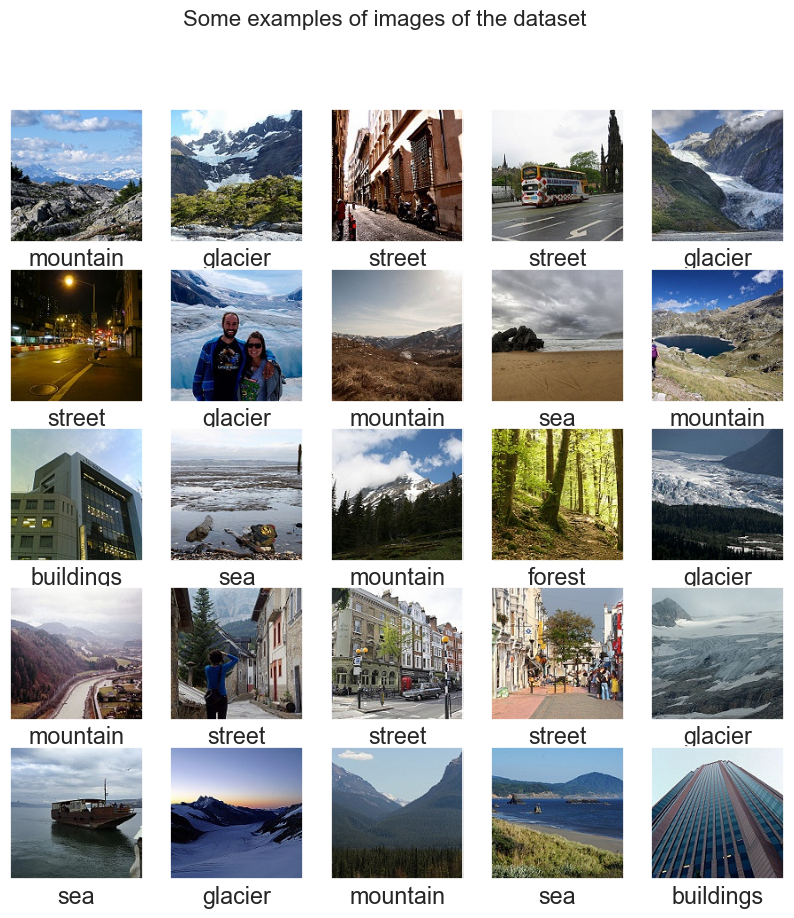

In [13]:
display_examples(class_names, x_train, y_train)

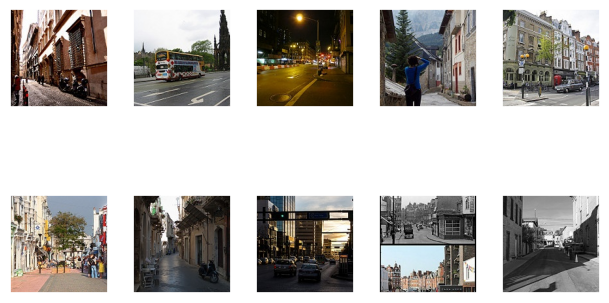

In [14]:
no=1
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == no][i]
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 步驟2：資料清理，此步驟無需進行

## 步驟3：進行特徵工程，將特徵縮放成(0, 1)之間

In [15]:
x_train_norm, x_test_norm = x_train , x_test 
# x_train_norm[0]

## 步驟4：資料分割，此步驟無需進行，載入資料時，已經切割好了

## 步驟5：建立模型結構

In [16]:
# 建立模型
model = tf.keras.models.Sequential([
    # model 1 accuracy = 76%
  tf.keras.layers.Conv2D(64, (3, 3),input_shape=(150, 150, 3), activation='relu'),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),                
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation='softmax')

  # model 2 ... GPU P100
  # tf.keras.layers.Conv2D(200,kernel_size=(3,3),input_shape=(150, 150, 3), activation='relu'),
  # tf.keras.layers.Conv2D(180,kernel_size=(3,3), activation='relu'),
  # tf.keras.layers.MaxPool2D(5,5),
  # tf.keras.layers.Conv2D(180,kernel_size=(3,3),activation='relu'),
  # tf.keras.layers.Conv2D(140,kernel_size=(3,3),activation='relu'),
  # tf.keras.layers.Conv2D(100,kernel_size=(3,3),activation='relu'),
  # tf.keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
  # tf.keras.layers.MaxPool2D(5,5),
  # tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(180,activation='relu'),
  # tf.keras.layers.Dense(100,activation='relu'),
  # tf.keras.layers.Dense(50,activation='relu'),
  # tf.keras.layers.Dropout(rate=0.5),
  # tf.keras.layers.Dense(6,activation='softmax')

  # model 3 ... colab out of RAM
  # tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(150, 150, 3), activation='relu'),
  # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  # tf.keras.layers.BatchNormalization(),
  
  # tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005), activation='relu'),
  # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  # tf.keras.layers.BatchNormalization(),
  
  # tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005), activation='relu'),
  # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  # tf.keras.layers.BatchNormalization(),
  
  # tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(units=256, activation='relu'),
  # tf.keras.layers.Dropout(0.5),
  # tf.keras.layers.Dense(units=6, activation='softmax')

])

In [17]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 170528)            0         
                                                                 
 dense (Dense)               (None, 128)               21827712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

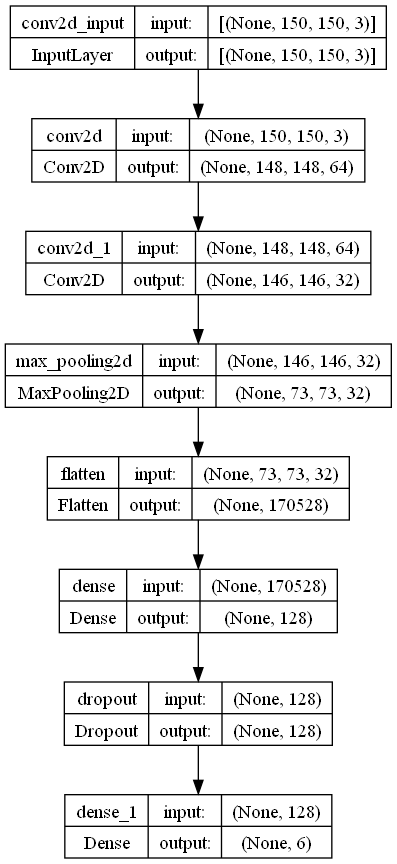

In [18]:
# 顯示模型的彙總資訊
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [19]:
# 模型訓練
# callback: https://ithelp.ithome.com.tw/articles/10234641
# 自訂 callback: https://ithelp.ithome.com.tw/articles/10235293
history = model.fit(x_train_norm, y_train, epochs=7, validation_split=0.3)

Epoch 1/7
307/307 [==============================] - 337s 1s/step - loss: 1.2108 - accuracy: 0.5525 - val_loss: 0.9568 - val_accuracy: 0.6272
Epoch 2/7
307/307 [==============================] - 342s 1s/step - loss: 0.7026 - accuracy: 0.7364 - val_loss: 0.7324 - val_accuracy: 0.7321
Epoch 3/7
307/307 [==============================] - 414s 1s/step - loss: 0.4213 - accuracy: 0.8502 - val_loss: 0.7401 - val_accuracy: 0.7376
Epoch 4/7
307/307 [==============================] - 384s 1s/step - loss: 0.2427 - accuracy: 0.9198 - val_loss: 0.9160 - val_accuracy: 0.7290
Epoch 5/7
307/307 [==============================] - 333s 1s/step - loss: 0.1248 - accuracy: 0.9611 - val_loss: 1.0163 - val_accuracy: 0.7193
Epoch 6/7
307/307 [==============================] - 303s 988ms/step - loss: 0.0951 - accuracy: 0.9709 - val_loss: 1.0959 - val_accuracy: 0.7523
Epoch 7/7
307/307 [==============================] - 303s 987ms/step - loss: 0.0549 - accuracy: 0.9852 - val_loss: 1.2669 - val_accuracy: 0.7340


In [20]:
# 檢查 history 所有鍵值
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

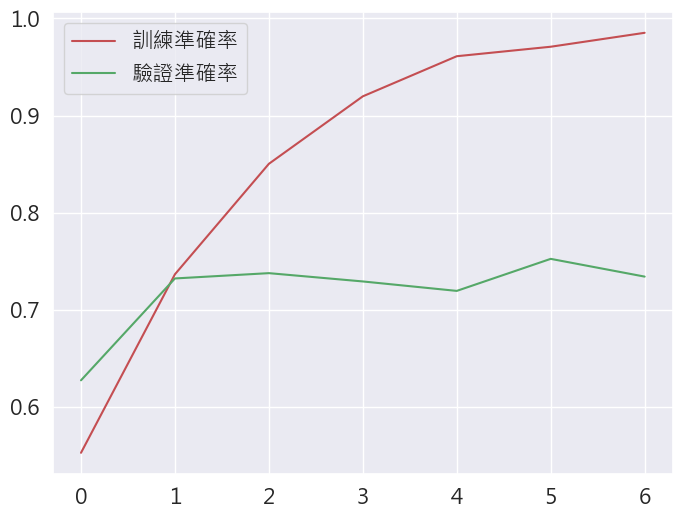

In [21]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.legend()
plt.show()

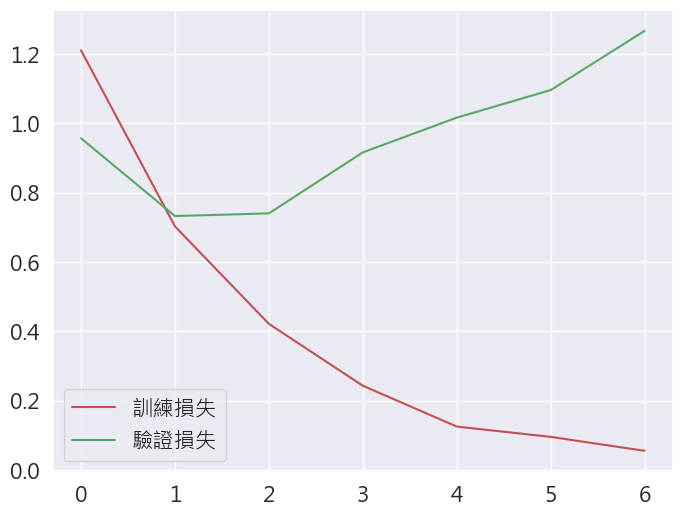

In [22]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'r', label='訓練損失')
plt.plot(history.history['val_loss'], 'g', label='驗證損失')
plt.legend()
plt.show()

## 步驟7：評分(Score Model)

In [23]:
# 評分(Score Model)
score=model.evaluate(x_test_norm, y_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

loss: 1.2437
accuracy: 0.7350


In [24]:
# 實際預測 20 筆資料
# predictions = model.predict_classes(x_test_norm)
import numpy as np
predictions = np.argmax(model.predict(x_test_norm), axis=-1)

# 比對
print('actual    :', y_test[0:20])
print('prediction:', predictions[0:20])

94/94 [==============================] - 11s 120ms/step
actual    : [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
prediction: [4 3 3 3 4 0 3 4 3 3 3 3 3 1 3 3 3 4 3 3]


In [25]:
# 顯示第 5 筆的機率
import numpy as np

predictions = model.predict(x_test_norm[4:5])
print(f'預測機率: {np.around(predictions, 3)}')

1/1 [==============================] - 0s 36ms/step
預測機率: [[0.    0.    0.    0.014 0.986 0.   ]]


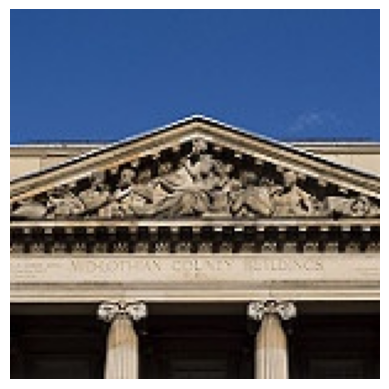

In [26]:
# 顯示第 5 筆圖像
X2 = x_test[4,:,:]
plt.imshow(X2)
plt.axis('off')
plt.show() 

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [27]:

# 模型存檔
tf.keras.models.save_model(model,'./OUT_MODEL')

# 模型載入
# model = tf.keras.models.load_model('image_model.h5')
loaded_model = tf.keras.models.load_model('./OUT_MODEL')

INFO:tensorflow:Assets written to: ./OUT_MODEL\assets


INFO:tensorflow:Assets written to: ./OUT_MODEL\assets


## 步驟10：新資料預測

1/1 [==============================] - 0s 31ms/step
sea


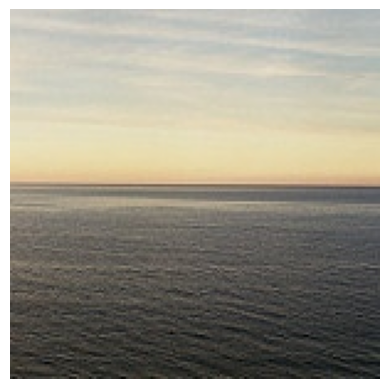

In [30]:
# 使用實際圖像驗證
X0 = cv2.imread('./input/seg_pred/seg_pred/528.jpg')
X1 = cv2.cvtColor(X0, cv2.COLOR_BGR2RGB)
X1 = cv2.resize(X1, IMAGE_SIZE) 
X1 = np.array(X1, dtype = 'float32') / 255.0
plt.grid(False)
plt.axis('off')
plt.imshow(X1)
X2 = X1.reshape(1,X1.shape[0],X1.shape[1],X1.shape[2])
# 預測

predictions = np.argmax(loaded_model.predict(X2), axis=-1)
print(class_names[predictions[0]])

In [31]:
model.predict(X2)

1/1 [==============================] - 0s 41ms/step


array([[1.4545651e-01, 2.0479081e-06, 5.2602135e-04, 1.8402045e-04,
        8.5379052e-01, 4.0902542e-05]], dtype=float32)

In [32]:
np.sum(model.predict(X2))

1/1 [==============================] - 0s 36ms/step


1.0

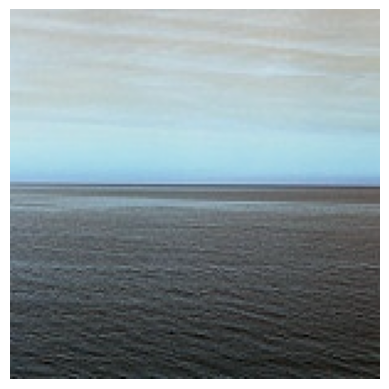

In [33]:
plt.imshow(X0)

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

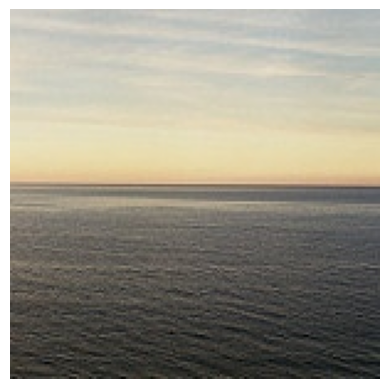

In [34]:
# 繪製點陣圖 resize
plt.imshow(X1)

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

In [36]:
fig_cnt = 0
for root, dirs, files in os.walk('./input/seg_pred/seg_pred/'):
    for file_name in files:
        print(file_name)
        X0 = cv2.imread(f'./input/seg_pred/seg_pred/{file_name}')
        X1 = cv2.cvtColor(X0, cv2.COLOR_BGR2RGB)
        X1 = cv2.resize(X1, IMAGE_SIZE) 
        X1 = np.array(X1, dtype = 'float32') / 255.0
        X2 = X1.reshape(1,X1.shape[0],X1.shape[1],X1.shape[2])
        # 預測
        predictions = np.argmax(loaded_model.predict(X2), axis=-1)
        print(class_names[predictions[0]])    
        fig_cnt += 1
        if fig_cnt > 10:
            break

10004.jpg
1/1 [==============================] - 0s 32ms/step
buildings
10005.jpg
1/1 [==============================] - 0s 38ms/step
sea
10012.jpg
1/1 [==============================] - 0s 40ms/step
street
10013.jpg
1/1 [==============================] - 0s 40ms/step
forest
10017.jpg
1/1 [==============================] - 0s 33ms/step
mountain
10021.jpg
1/1 [==============================] - 0s 35ms/step
forest
1003.jpg
1/1 [==============================] - 0s 32ms/step
sea
10034.jpg
1/1 [==============================] - 0s 32ms/step
glacier
10038.jpg
1/1 [==============================] - 0s 32ms/step
sea
10040.jpg
1/1 [==============================] - 0s 33ms/step
street
10043.jpg
1/1 [==============================] - 0s 31ms/step
sea


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [37]:
import pandas as pd 
predictions = np.argmax(model.predict(x_test_norm), axis=-1)
pd.crosstab(y_test, predictions, rownames=['實際值'], colnames=['預測值'])

94/94 [==============================] - 11s 117ms/step


預測值,0,1,2,3,4,5
實際值,,,,,,
0,357,1,68,20,77,2
1,5,321,9,111,8,47
2,55,11,377,25,82,3
3,13,44,9,318,31,22
4,39,6,53,14,393,5
5,4,9,1,19,2,439
